## Multi-Classification and Regression Model over Galaxy Zoo Dataset

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from torch.nn import *
import pandas as pd

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [0]:
# ! {sys.executable} -m pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
! mkdir -p ~/.kaggle/
! cp kaggle.json ~/.kaggle/

In [0]:
path = Config.data_path()/'Galaxy'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/Galaxy')

In [0]:
! kaggle competitions download -c galaxy-zoo-the-galaxy-challenge -p {path}
! unzip -q -n {path}/images_training_rev1.zip -d {path}
! unzip -q -n {path}/training_solutions_rev1.zip -d {path}

  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 79.8MB/s]
  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 86.6MB/s]
  0% 0.00/520k [00:00<?, ?B/s]
100% 520k/520k [00:00<00:00, 71.6MB/s]
 99% 784M/792M [00:09<00:00, 108MB/s] 
100% 792M/792M [00:09<00:00, 85.8MB/s]
 99% 0.99G/1.01G [00:11<00:00, 87.2MB/s]
100% 1.01G/1.01G [00:11<00:00, 91.3MB/s]
  0% 0.00/4.63M [00:00<?, ?B/s]
100% 4.63M/4.63M [00:00<00:00, 76.3MB/s]


In [0]:
path.ls()

[PosixPath('/root/.fastai/data/Galaxy/images_test_rev1.zip'),
 PosixPath('/root/.fastai/data/Galaxy/training_solutions_rev1.zip'),
 PosixPath('/root/.fastai/data/Galaxy/training_solutions_rev1.csv'),
 PosixPath('/root/.fastai/data/Galaxy/all_ones_benchmark.zip'),
 PosixPath('/root/.fastai/data/Galaxy/images_training_rev1'),
 PosixPath('/root/.fastai/data/Galaxy/central_pixel_benchmark.zip'),
 PosixPath('/root/.fastai/data/Galaxy/images_training_rev1.zip'),
 PosixPath('/root/.fastai/data/Galaxy/all_zeros_benchmark.zip')]

# Multi Regression and Classification

Let's take a look at how the data is provided to us in the csv file. 

In [0]:
df = pd.read_csv(path/'training_solutions_rev1.csv')
df.head(10)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.000000,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.000000,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.000000,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.000000,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.000000,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.000000,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.000000,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.000000,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.000000,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,100122,0.738832,0.238159,0.023009,0.000000,0.238159,0.000000,0.238159,0.000000,0.238159,0.000000,0.000000,0.238159,0.000000,0.197930,0.802070,0.066807,0.663691,0.008335,0.0,0.000000,0.049482,0.098965,0.049482,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,100123,0.462492,0.456033,0.081475,0.000000,0.456033,0.000000,0.456033,0.000000,0.456033,0.000000,0.000000,0.456033,0.000000,0.687647,0.312353,0.388158,0.074334,0.000000,0.0,0.000000,0.000000,0.000000,0.213858,0.473789,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,100128,0.687783,0.288344,0.023873,0.000000,0.288344,0.069098,0.219246,0.000000,0.288344,0.067228,0.123625,0.027836,0.069656,0.473888,0.526112,0.482483,0.205300,0.000000,0.0,0.067766,0.033646,0.000000,0.304710,0.067766,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,100134,0.021834,0.976952,0.001214,0.021751,0.955201,0.313077,0.642124,0.546491,0.408711,0.160096,0.760688,0.034417,0.000000,0.611499,0.388501,0.010917,0.010917,0.000000,0.0,0.032377,0.064143,0.450225,0.000000,0.032377,0.032377,0.000000,0.0,0.021751,0.207253,0.152044,0.187194,0.000000,0.000000,0.054649,0.081974,0.081974,0.327894
9,100143,0.269843,0.730157,0.000000,0.730157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.410635,0.589365,0.000000,0.000000,0.269843,0.0,0.000000,0.034117,0.000000,0.136878,0.239640,0.000000,0.561429,0.0,0.168728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
col_list = [i for i in range(1,38)]

In [0]:
tfms = get_transforms(flip_vert=True)

We create the Dataset in the following cells as per the fastai data block API. Since this is a multi regression problem, we define the label class as FloatList. 

In [0]:
np.random.seed(42)
src = (ImageList.from_df(df, path/"images_training_rev1", suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(cols = col_list, label_cls = FloatList))
src

# file_name = "item_list.txt"
# ImageList.from_folder(path, include = "images_training_rev1").to_text(file_name)
# ! cat {path/file_name} | head

LabelLists;

Train: LabelList (49263 items)
x: ImageList
Image (3, 424, 424),Image (3, 424, 424),Image (3, 424, 424),Image (3, 424, 424),Image (3, 424, 424)
y: FloatList
[0.383147 0.616853 0.       0.       0.616853 0.038452 0.578401 0.418398 0.198455 0.       0.104752 0.512101 0.
 0.054453 0.945547 0.201463 0.181684 0.       0.       0.027227 0.       0.027227 0.       0.       0.       0.
 0.       0.       0.279952 0.138445 0.       0.       0.092886 0.       0.       0.       0.325512],[0.327001 0.663777 0.009222 0.031178 0.632599 0.46737  0.165229 0.591328 0.041271 0.       0.236781 0.160941 0.234877
 0.189149 0.810851 0.       0.135082 0.191919 0.       0.       0.140353 0.       0.048796 0.       0.       0.012414
 0.       0.018764 0.       0.131378 0.45995  0.       0.591328 0.       0.       0.       0.      ],[0.765717 0.177352 0.056931 0.       0.177352 0.       0.177352 0.       0.177352 0.       0.11779  0.059562 0.
 0.       1.       0.       0.741864 0.023853 0.       0

In [0]:
data = (src.transform(tfms, size=224)
        .databunch().normalize())

`show_batch` still works, and show us the different labels separated by `;`.

/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


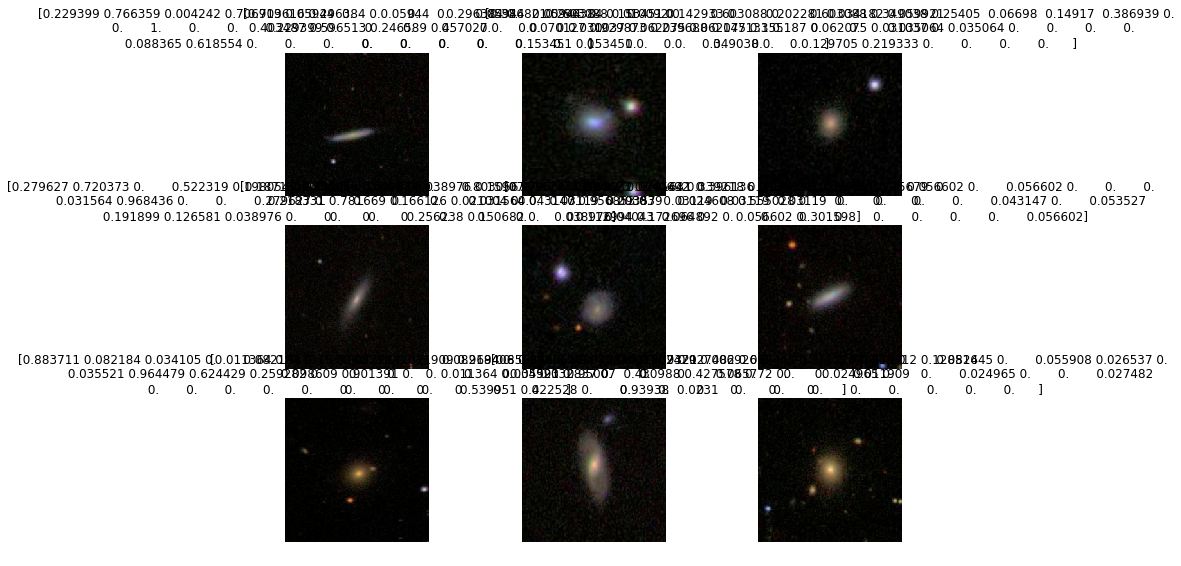

In [0]:
# data.classes
data.show_batch(rows=3, figsize=(12,9))


Multi regression problems are generally dealt by using the BCE Loss function provided in the torch.nn

In [0]:
arch = models.resnet34

In [0]:
learn = cnn_learner(data, arch, metrics=[root_mean_squared_error])
learn.loss = BCELoss

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 17888739.98it/s]


We use the LR Finder to pick a good learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


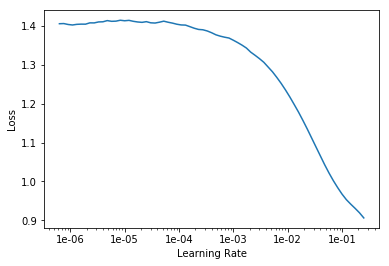

In [0]:
#always remains the same when we initialize the cnn.
learn.lr_find()
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.03

In [0]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.017840,0.015908,0.126023,08:21
1,0.016080,0.014021,0.118264,08:22
2,0.012710,0.016156,0.107308,08:18
3,0.010610,0.020874,0.112237,08:20


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


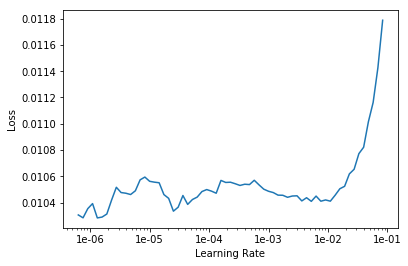

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, slice(3e-3, 1e-2))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.012748,0.041836,0.165112,08:14
1,0.011218,0.013595,0.109374,08:03
2,0.009878,0.027462,0.113141,08:00


In [0]:
# learn.save('F-MLML-34)')
model_save_name = "Galaxy-F-BCE-34"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.save(path)

...And fine-tune the whole model:

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


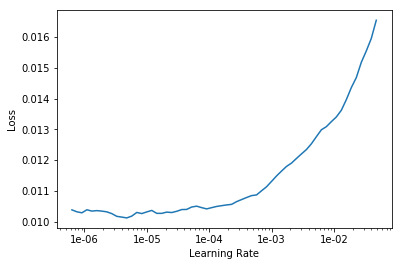

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.011322,0.016484,0.117529,08:16
1,0.010382,0.014282,0.102584,08:17
2,0.009604,0.008312,0.091046,08:14
3,0.008681,0.012574,0.097830,08:16
4,0.008292,0.007447,0.085624,08:14


In [0]:
model_save_name = "Galaxy-UF-BCE-stage1"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.save(path)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


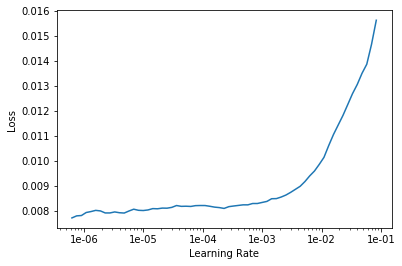

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.009852,0.008298,0.090976,08:11
1,0.008857,0.008679,0.090825,08:11
2,0.008211,0.007137,0.084139,08:10


In [0]:
model_save_name = "Galaxy-UF-BCE-stage2"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.save(path)

In [0]:
learn.fit_one_cycle(3, slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.008045,0.007758,0.086694,08:10
1,0.007921,0.007275,0.084407,08:20
2,0.007918,0.007168,0.084254,08:33


In [0]:
learn.fit_one_cycle(3, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007901,0.007893,0.085564,08:26
1,0.007840,0.010390,0.091644,08:23
2,0.007708,0.006855,0.082649,08:22


In [0]:
model_save_name = "Galaxy-UF-BCE-stage3"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.save(path)

In [0]:
learn.fit_one_cycle(3, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007746,0.006994,0.083310,08:21
1,0.007817,0.006967,0.083236,08:18
2,0.007789,0.007045,0.083563,08:19


In [0]:
model_save_name = "Galaxy-UF-BCE-stage4"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.save(path)

# Initial Submission

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [0]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [0]:
path = Config.data_path()/'Galaxy'
path.mkdir(parents=True, exist_ok=True)
! unzip -q -n {path}/images_test_rev1.zip -d {path}

In [0]:
test = ImageList.from_folder(path/'images_test_rev1')
# test[:5]

file_name = "test_list.txt"
ImageList.from_folder(path, include = "images_test_rev1").to_text(file_name)
! cat {path/file_name} | head

images_test_rev1/119997.jpg
images_test_rev1/453839.jpg
images_test_rev1/183146.jpg
images_test_rev1/647949.jpg
images_test_rev1/753091.jpg
images_test_rev1/167462.jpg
images_test_rev1/841874.jpg
images_test_rev1/480720.jpg
images_test_rev1/870664.jpg
images_test_rev1/697252.jpg


In [0]:
model_save_name = "Galaxy-UF-BCE-stage4"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.load(path)

In [0]:
path = Path(F"/content/gdrive/My Drive/")
learn.export(path/"export.pkl")

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
preds = preds.numpy()

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df_t = pd.DataFrame(preds)
df_t.insert(loc=0, column="Galaxy", value=fnames)
df_t.columns = df.columns
df_t

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,719879,0.553015,0.416762,0.028944,0.247133,0.168121,0.026337,0.140398,0.061905,0.105918,0.142417,0.011012,0.002618,0.009284,0.210626,0.788987,0.000685,0.129968,0.422603,0.008756,0.005958,0.027178,0.079756,0.067015,0.007696,0.006380,0.022107,0.003385,0.219240,0.024048,0.020380,0.013350,0.003978,0.022578,0.000693,-0.000685,-0.000475,0.032728
1,248262,0.269004,0.604737,0.125039,0.495076,0.109358,0.050734,0.058094,0.019447,0.089500,0.028751,0.048520,0.018734,0.011996,0.251503,0.748313,0.061511,0.024101,0.182331,0.020807,0.018043,0.027970,0.021224,0.133444,0.006574,0.018356,0.240362,0.049609,0.203176,-0.007998,-0.001923,0.029806,-0.006156,0.001652,0.006932,0.010448,0.011592,-0.008805
2,645162,0.271877,0.712918,0.014596,0.013258,0.699380,0.044000,0.655553,0.561920,0.137509,0.023390,0.309420,0.309161,0.057606,0.122876,0.876867,0.072317,0.198681,0.000711,0.041264,0.012611,0.028382,0.019741,0.013926,0.005295,0.001030,0.012272,-0.000087,0.000861,0.323126,0.190438,0.049519,0.042921,0.206906,0.059767,0.026449,0.024827,0.200853
3,756518,0.641430,0.326450,0.031894,0.009736,0.316157,0.029069,0.286900,0.144081,0.171786,0.107882,0.118338,0.049083,0.041390,0.138548,0.861250,0.081629,0.548448,0.011562,0.011366,0.009245,0.031250,0.045919,0.037860,0.000590,0.001926,0.003299,0.000667,0.005668,0.077550,0.050594,0.016391,0.014108,0.042265,0.006659,0.002638,0.003776,0.074375
4,217008,0.020794,0.975109,0.003719,0.044146,0.930536,0.744168,0.186165,0.786378,0.144137,-0.010035,0.252965,0.615649,0.071869,0.242995,0.756706,-0.001655,0.025319,-0.002824,0.127589,0.014364,0.033083,0.016636,0.040886,0.011223,0.000019,0.034129,0.004355,0.005455,0.226751,0.410403,0.150169,0.025908,0.635735,0.051225,0.012883,0.000433,0.062021
5,383824,0.443386,0.540627,0.015653,0.060553,0.480172,0.042482,0.437650,0.136985,0.343218,0.008152,0.171341,0.267696,0.033341,0.085696,0.913988,0.025500,0.387769,0.030448,0.014146,0.007981,0.022662,0.026597,0.014982,-0.001241,0.001757,0.044791,0.005671,0.009926,0.070133,0.045070,0.021559,0.008749,0.026709,0.004357,0.004067,0.007492,0.085824
6,310677,0.826591,0.133207,0.040135,0.017064,0.115909,0.019963,0.096315,0.018154,0.097793,-0.001569,0.032425,0.066355,0.018326,0.109492,0.890243,0.505992,0.311693,0.009238,0.000668,0.019268,0.015908,0.004438,0.048706,0.017578,0.002741,0.013695,0.002771,0.000276,0.008294,0.008205,0.001730,-0.000619,0.006488,-0.000100,-0.000106,-0.000171,0.012572
7,392169,0.597883,0.379029,0.022730,0.019714,0.359249,0.023246,0.336187,0.159490,0.199835,0.007145,0.072847,0.222275,0.058313,0.160066,0.839606,0.279583,0.305678,0.012474,0.058565,0.018822,0.029476,0.023006,0.025032,0.004077,0.001877,0.012358,0.000423,0.006678,0.073462,0.057808,0.028981,0.022865,0.056608,0.005047,0.001124,0.002285,0.072968
8,992690,0.520182,0.456165,0.024058,0.015376,0.440396,0.053061,0.387241,0.064204,0.376168,-0.002608,0.129068,0.285089,0.028414,0.052901,0.946819,0.415669,0.105338,-0.000931,0.008818,0.008146,0.006736,0.004667,0.016983,0.009473,-0.001027,0.010134,0.000033,0.004986,0.041810,0.015964,0.006140,0.000169,0.000642,0.003219,0.003556,0.006626,0.050190
9,563610,0.706037,0.279581,0.013712,0.184506,0.094864,0.022073,0.072341,0.013329,0.080899,0.013722,0.040572,0.031190,0.007297,0.061494,0.938223,-0.005361,0.250813,0.459869,0.011108,0.005760,0.010782,0.008683,0.020932,0.004700,-0.002214,0.099915,0.006731,0.076603,0.008914,0.003086,0.000284,-0.002005,0.004262,0.002135,-0.000498,-0.001068,0.009528


In [0]:
# path = Path(F"/content/gdrive/My Drive/")
path = Config.data_path()/'Galaxy'
path.mkdir(parents=True, exist_ok=True)
df_t.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit galaxy-zoo-the-galaxy-challenge -f {path/'submission.csv'} -m "My submission"
# kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

100% 33.5M/33.5M [00:01<00:00, 18.8MB/s]
Successfully submitted to Galaxy Zoo - The Galaxy Challenge

Private Leaderboard score: 0.08749 (18th) <br>
Public Leaderboard score: 0.08492 (15th)

# Improvement by going big

In [0]:
model_save_name = "Galaxy-UF-BCE-stage4"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.load(path)

We add multiple transformations to get improved results. The details of these transformations can be found in the fastai documentation under data transformation

In [0]:
tfms = get_transforms(flip_vert=True, max_rotate = 25.0, max_zoom=1.2, max_lighting=0.5, max_warp=0.2, p_affine=0.75)

In [0]:
data = (src.transform(tfms, size=400)
        .databunch().normalize())

In [0]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


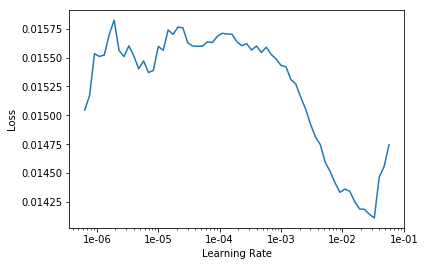

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 5e-3
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.010131,0.008611,0.092199,19:58
1,0.009252,0.007710,0.087427,20:19
2,0.008711,0.007331,0.085447,19:31


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


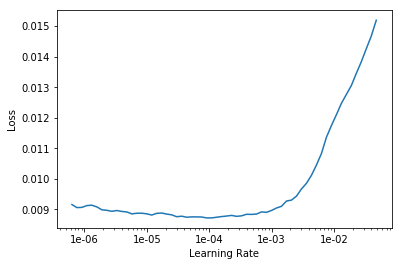

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
model_save_name = "Galaxy-F-BCE-400"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.save(path)

In [0]:
learn.load(path)

In [0]:
learn.fit_one_cycle(5, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.009170,0.008876,0.091987,20:32
1,0.009226,0.009695,0.094636,20:38
2,0.008610,0.008060,0.088820,20:45
3,0.008058,0.006869,0.082756,20:45
4,0.007548,0.006656,0.081451,20:46


In [0]:
learn.fit_one_cycle(3, slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007711,0.007247,0.084102,20:44
1,0.007622,0.006576,0.080981,21:13
2,0.007503,0.006625,0.081206,21:15


In [0]:
model_save_name = "Galaxy-UF-BCE-400-stage1"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.save(path)

In [0]:
model_save_name = "Galaxy-UF-BCE-400-stage1"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.load(path)

In [0]:
learn.fit_one_cycle(3, slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007691,0.006723,0.081708,18:09
1,0.007554,0.006630,0.081066,18:10
2,0.007576,0.006615,0.081129,18:08


In [0]:
model_save_name = "Galaxy-UF-BCE-400-stage2"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.save(path)

In [0]:
learn.fit_one_cycle(3, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007391,0.006616,0.081086,18:03
1,0.007570,0.006697,0.081524,18:11
2,0.007405,0.006646,0.081219,18:18


In [0]:
model_save_name = "Galaxy-UF-BCE-400-stage3"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.save(path)

In [0]:
model_save_name = "Galaxy-UF-BCE-400-stage3"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.load(path)

In [0]:
learn.fit_one_cycle(1, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007522,0.007022,0.082572,19:19


In [0]:
learn.fit_one_cycle(3, slice(5e-5, 3e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007523,0.008996,0.086495,19:43
1,0.007565,0.007797,0.083470,20:09
2,0.007480,0.006752,0.081805,20:09


In [0]:
learn.fit_one_cycle(3, slice(5e-5, 3e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007552,0.006650,0.081365,20:38
1,0.007586,0.249812,0.180580,20:38
2,0.007377,0.007041,0.082276,20:42


In [0]:
learn.fit_one_cycle(3, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007450,0.007395,0.083612,20:30
1,0.007408,0.007398,0.083434,20:35
2,0.007433,0.006632,0.081228,20:36


In [0]:
model_save_name = "Galaxy-UF-BCE-400-random"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.save(path)

# Final Submission

In [0]:
model_save_name = "Galaxy-UF-BCE-400-random"
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.load(path)

In [0]:
path = Path(F"/content/gdrive/My Drive/")
learn.export(path/"export.pkl")

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
preds = preds.numpy()

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df_t = pd.DataFrame(preds)
df_t.insert(loc=0, column="Galaxy", value=fnames)
df_t.columns = df.columns
df_t.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,119997,0.245765,0.739854,0.014245,0.026384,0.713255,0.075353,0.637963,0.389678,0.323812,0.023642,0.306109,0.329838,0.053922,0.414075,0.585579,0.017121,0.224874,0.003937,0.082941,0.023648,0.057580,0.055701,0.115518,0.075054,0.005019,0.022055,0.001042,0.002900,0.227985,0.133929,0.027728,0.039808,0.089273,0.028915,0.012826,0.015837,0.203867
1,453839,0.148292,0.837650,0.013690,0.023279,0.814494,0.572976,0.241228,0.287596,0.527111,0.098207,0.472730,0.229588,0.014551,0.398845,0.600550,0.039564,0.114891,-0.005822,0.113547,0.011026,0.058136,0.132378,0.067969,0.009412,0.004553,0.012862,0.002737,0.007817,0.140229,0.122402,0.025712,0.008796,0.109616,0.013779,0.010067,0.009003,0.132263
2,183146,0.042953,0.945373,0.011137,0.014885,0.930852,0.435262,0.495736,0.896570,0.033849,0.116836,0.584398,0.203595,0.026970,0.267820,0.731864,0.013306,0.034884,-0.005109,0.013031,0.009962,0.081845,0.094592,0.050857,0.015951,0.002802,0.011701,0.001548,0.001134,0.260481,0.481294,0.155457,0.032702,0.525530,0.164705,0.057461,0.025161,0.097403
3,647949,0.294841,0.690593,0.013883,0.338273,0.353036,0.104862,0.248115,0.237861,0.115146,0.015185,0.116940,0.178389,0.043904,0.238647,0.761167,0.007513,0.085953,0.200998,0.043039,0.017690,0.052398,0.042318,0.051328,0.020204,0.014287,0.229313,0.038147,0.071346,0.043100,0.085246,0.109455,0.022172,0.143346,0.008094,0.003225,0.002039,0.059849
4,753091,0.261269,0.726495,0.011993,0.556651,0.169957,0.098483,0.071144,0.014571,0.155510,0.010389,0.069897,0.076520,0.014153,0.107034,0.892532,0.006864,0.091162,0.163555,0.007740,0.007284,0.027809,0.021058,0.030448,-0.002274,0.016075,0.428376,0.085489,0.042534,0.008164,0.004813,0.001945,-0.000247,0.002062,-0.002115,-0.000189,0.000857,0.015224


In [0]:
# path = Path(F"/content/gdrive/My Drive/")
path = Config.data_path()/'Galaxy'
path.mkdir(parents=True, exist_ok=True)
df_t.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit galaxy-zoo-the-galaxy-challenge -f {path/'submission.csv'} -m "My submission"
# kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

100% 33.6M/33.6M [00:02<00:00, 16.6MB/s]
Successfully submitted to Galaxy Zoo - The Galaxy Challenge

Private Leaderboard score: 0.08393 (13th) <br>
Public Leaderboard score: 0.08272 (10th)